# DATA EDA
* 정기 일정 : 22/11/14 ~ 22/11/24
* 작성자 : 전유빈

## DATA LOAD

* 모든 브랜드를 통합하여 제품을 추천해줄 것인가?
* 구매이력이 있는 상품만 사용할 것인지?
* 아이템의 카테고리 통일 필요

In [1]:
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

raw_item = pd.read_csv('s3://poc-descente/raw_data/item.csv', encoding='cp949')
raw_order = pd.read_csv('s3://poc-descente/raw_data/order.csv', encoding='cp949')
raw_users = pd.read_csv('s3://poc-descente/raw_data/users_1125.csv', encoding='cp949')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Data Filtering
#### 고객사 협의사항
- Brand : Y (영애슬릿) 현재 운영하지 않으므로 제외
- 인당 구매 개수 비정상 고객 ID (비회원 구매) 제외
- PROD_CD : 첫글자 7(17년도)이하 및 TK 상품 제외
- 가격 0 인 제품 제외

In [ ]:
## order
raw_order['BRAND_CD'] = raw_order['PROD_CD'].str.split('', n=2, expand=True)[1] ## 브랜드코드 추출
order = raw_order[raw_order['BRAND_CD']!='Y'] ## 브랜드 Y(영애슬릿) 제외
order = order[order['USR_ID']!=raw_order['USR_ID'].value_counts().head(1).index[0]] ## 인당 구매개수 비정상 고객(비회원 구매) 제외
order = order[order['PROD_CD'].str[:2] != 'TK'] ## TK(TICKET)상품 제외
order = order[order['PROD_CD'] != 2800]
print('order loss rate version 1')
print(raw_order.shape)
print(order.shape)
print(1-len(order)/len(raw_order))

## item
item = raw_item[raw_item['ITEM_NM'] != 'TICKET'] ## TK(TICKET)상품 제외 (가격 0인 제품도 같이 제외되었음)
item = item[item['PROD_CD'].str.split('',n = 3, expand = True)[2].isin(['0','M','N','O'])] ## 연도 정보 0, M, N, O에 해당되는 데이터만 추출
print('item loss rate version 1')
print(raw_item.shape)
print(item.shape)
print(1 - len(item)/len(raw_item))

## user
users = raw_users[raw_users['AGE'] != 2022]
print('users loss rate version 1')
print(raw_users.shape)
print(users.shape)
print(1 - len(users)/len(raw_users))

print("")
## 서로 포함하는 데이터만 추출
order = order[order['USR_ID'].isin(raw_users['USR_ID'])] ## User 정보 있는 데이터만 추출
order = order[order['PROD_CD'].isin(item['PROD_CD'])] ## User 정보 있는 데이터만 추출
order.drop_duplicates(inplace = True)
order.reset_index(drop = True, inplace = True)
print('order loss rate version 2')
print(order.shape)
print(1-len(order)/len(raw_order))

item = item[item['PROD_CD'].isin(order['PROD_CD'])]
item.reset_index(drop = True, inplace = True)
item.drop_duplicates(inplace = True)
print('item loss rate version 2')
print(item.shape)
print(1 - len(item)/len(raw_item))

users = users[users['USR_ID'].isin(order['USR_ID'])]
users.reset_index(drop = True, inplace = True)
users.drop_duplicates(inplace = True)
print('users loss rate version 2')
print(users.shape)
print(1 - len(users)/len(raw_users))

order loss rate version 1
(378520, 11)
(371863, 11)
0.017586917468033425
item loss rate version 1
(82428, 13)
(25780, 13)
0.6872421992526812
users loss rate version 1
(482851, 10)
(482809, 10)
8.698335511370114e-05

order loss rate version 2
(349767, 11)
0.0759616400718588
item loss rate version 2
(16641, 13)
0.7981147182996069
users loss rate version 2
(124623, 10)
0.7419017460873023


## Order Data

In [4]:
## 2021년 11월 1일 ~ 2022년 11월 1일 (1년치 데이터)
order['REG_DT'] = pd.to_datetime(order['REG_DT'])
print(f'{order["REG_DT"].min()} ~ {order["REG_DT"].max()}')

2021-11-01 00:00:00 ~ 2022-11-01 00:00:00


In [5]:
## 결측치 없음
order.isna().sum()

ORD_NO         0
ORD_DTL_NO     0
USR_ID         0
PROD_CD        0
COLOR_CD       0
SIZE_CD        0
PROD_QTY       0
PROD_PRC       0
REG_DT         0
ORD_CHANNEL    0
BRAND_CD       0
dtype: int64

In [6]:
## USER_ID 컬럼 확인
buy_usr = pd.DataFrame(order['USR_ID'].value_counts()).sort_values('USR_ID', ascending = False)
print(f"인당 최대 구매 횟수 : {buy_usr['USR_ID'].max()}")
print(f"인당 최소 구매 횟수 : {buy_usr['USR_ID'].min()}")
print(f"인당 평균 구매 횟수 : {buy_usr['USR_ID'].mean()}")
print(f"2건 이상 구매자 : {len(buy_usr[buy_usr['USR_ID'] >= 2])}")
print(f"5건 이상 구매자 : {len(buy_usr[buy_usr['USR_ID'] >= 5])}")
print(f"10건 이상 구매자 : {len(buy_usr[buy_usr['USR_ID'] >= 100])}")
print(f"100건 이상 구매자 : {len(buy_usr[buy_usr['USR_ID'] >= 100])}")
print(f"200건 이상 구매자 : {len(buy_usr[buy_usr['USR_ID'] >= 200])}")

인당 최대 구매 횟수 : 298
인당 최소 구매 횟수 : 1
인당 평균 구매 횟수 : 2.8061278521228457
2건 이상 구매자 : 60362
5건 이상 구매자 : 15607
10건 이상 구매자 : 31
100건 이상 구매자 : 31
200건 이상 구매자 : 5


In [7]:
print(order[(order['PROD_QTY']<10)].shape)
print(order[(order['PROD_QTY']>=10) &(order['PROD_QTY']<100)].shape)
print(order[(order['PROD_QTY']>=100)].shape)

(349603, 11)
(161, 11)
(3, 11)


In [8]:
## 한번에 10개 이상 구매 고객
item[item['PROD_CD'].isin(order[order['PROD_QTY']>10]['PROD_CD'].unique())]['PROD_NM'].unique()

array(['여성 슬림핏 코튼 반팔티셔츠', 'DANKER (댄커)', '여성 에슬레져 멀티백',
       '남녀공용 베이직 본딩플리스 자켓', '남녀공용 친환경 코튼 스몰로고 반팔 티셔츠',
       '남성 프리즈런 소닉에어 러닝 반팔티셔츠', '남녀공용 스피릿 베이직캡', '스위스 스키팀 나일론 백팩',
       'DANKER 2.0 (댄커 2.0)', '액티브 초경량 패커블 아노락', '베이직 페이크삭스', '귀달이 앵클삭스',
       '스포츠베이직 삭스', 'GBR 트라이애슬론 사이클 슬링백 M', '트리컬러 하이삭스', '에너자이트 슈퍼',
       '스포츠베이직 숏 삭스', '유커스텀 1.0 (라운드넥 반팔)',
       '유커스텀 3.0 (STANDARD 소매 컬러 블록 반팔 상의)',
       '유커스텀 3.0 (STANDARD 소매 컬러 블록 반팔 상하의 세트)', '하이퍼 슬라이드', '아이싱 나스',
       '하이삭스', '[KPGA] 커먼 맥스 백팩', '러닝 베이직 암커버', '르플렉션 2.0',
       '나노 피그먼트 반팔 후드 아노락', '주니어 UV 차단 우븐 아노락 자켓', '썸머 마스크',
       '러닝 이지브리드 멀티 스카프', '워터컬러 그래픽 티셔츠', 'TOPI (토피)', '테니스 헤어밴드 아대 세트',
       '로즈 아치 반팔티', '남성 냉감 팔토시', '스포츠베이직 스니커즈', '베이직 팔토시',
       '유니 뒷그래픽 면 나시티', '시어서커 루즈핏 반팔 피스테', '딩키볼드'], dtype=object)

In [9]:
## 한번에 100개 이상 구매 고객
item[item['PROD_CD'].isin(order[order['PROD_QTY']>100]['PROD_CD'].unique())]['PROD_NM'].unique()

array(['GBR 트라이애슬론 사이클 슬링백 M', '[KPGA] 커먼 맥스 백팩'], dtype=object)

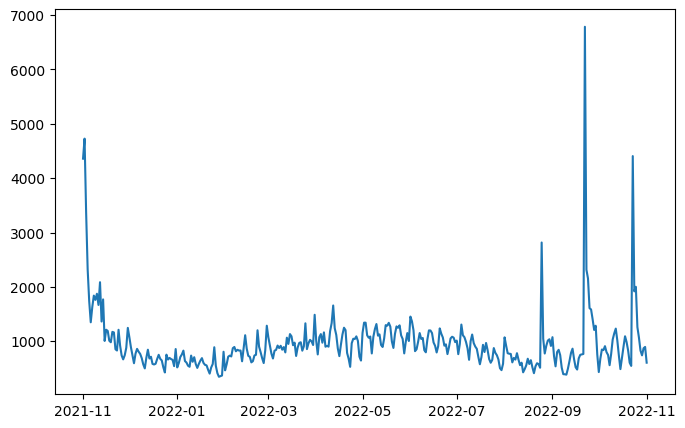

In [11]:
## 일자별 제품 구매 추이
temp = pd.DataFrame(order['REG_DT'].value_counts().sort_index())
temp.reset_index(drop = False, inplace = True)

plt.figure(figsize =(8,5))
plt.plot(temp['index'], temp['REG_DT'])
plt.show()

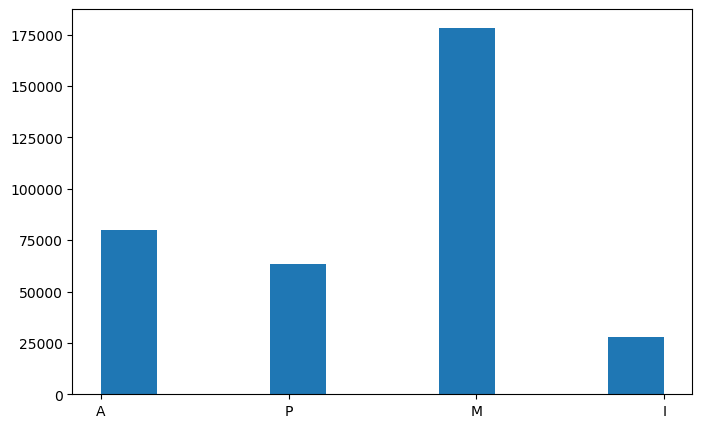

In [13]:
plt.figure(figsize =(8,5))
plt.hist(order['ORD_CHANNEL'])
plt.show()

## PreProcessing

## 구매 횟수 1인 데이터 제거
order = order[~order['USR_ID'].isin(buy_usr[buy_usr['USR_ID'] == 1].index)].copy()

In [15]:
for i in list(order):
    print(f'"{i}" column has {order[i].nunique()} unique values')

"ORD_NO" column has 242233 unique values
"ORD_DTL_NO" column has 349767 unique values
"USR_ID" column has 124644 unique values
"PROD_CD" column has 7583 unique values
"COLOR_CD" column has 782 unique values
"SIZE_CD" column has 157 unique values
"PROD_QTY" column has 25 unique values
"PROD_PRC" column has 524 unique values
"REG_DT" column has 366 unique values
"ORD_CHANNEL" column has 4 unique values
"BRAND_CD" column has 6 unique values


In [17]:
buy_prod = pd.DataFrame(order['PROD_CD'].value_counts()).sort_values('PROD_CD', ascending = False)
print(f"제품당 최대 구매 횟수 : {buy_prod['PROD_CD'].max()}")
print(f"제품당 최소 구매 횟수 : {buy_prod['PROD_CD'].min()}")
print(f"제품당 평균 구매 횟수 : {buy_prod['PROD_CD'].mean()}")
print(f"제품당 횟수 중앙값 : {buy_prod['PROD_CD'].median()}")
print(f"5건 이상 구매된 제품 : {len(buy_prod[buy_prod['PROD_CD'] >= 5])}")
print(f"10건 이상 구매된 제품 : {len(buy_prod[buy_prod['PROD_CD'] >= 100])}")
print(f"100건 이상 구매된 제품 : {len(buy_prod[buy_prod['PROD_CD'] >= 100])}")
print(f"200건 이상 구매된 제품 : {len(buy_prod[buy_prod['PROD_CD'] >= 200])}")

제품당 최대 구매 횟수 : 6879
제품당 최소 구매 횟수 : 1
제품당 평균 구매 횟수 : 46.12514835816959
제품당 횟수 중앙값 : 16.0
5건 이상 구매된 제품 : 5949
10건 이상 구매된 제품 : 831
100건 이상 구매된 제품 : 831
200건 이상 구매된 제품 : 350


In [19]:
# ## 100건 이상 구매된 제품
# print(item[item['PROD_CD'].isin(buy_prod[buy_prod['PROD_CD'] >= 100].index)]['PROD_NM'].unique(), '\n')

# ## 200건 이상 구매된 제품
# print(item[item['PROD_CD'].isin(buy_prod[buy_prod['PROD_CD'] >= 200].index)]['PROD_NM'].unique())

In [21]:
# ## 100건 이상 구매한 고객이 구매한 제품 (큰 특징 없음)
# item[item['PROD_CD'].isin(order[order['USR_ID'].isin(buy_usr[buy_usr['USR_ID'] >= 100].index)]['PROD_CD'])]['PROD_NM'].value_counts().sort_values(ascending = False).head(20)

# ## 200건 이상 구매한 고객이 구매한 제품 (큰 특징 없음)
# item[item['PROD_CD'].isin(order[order['USR_ID'].isin(buy_usr[buy_usr['USR_ID'] >= 200].index)]['PROD_CD'])]['PROD_NM'].value_counts().sort_values(ascending = False).head(20)

* 가격 기준을 order PROD_PRC와 item MALL_SALE_PRC중 어떤거로 봐야할까?

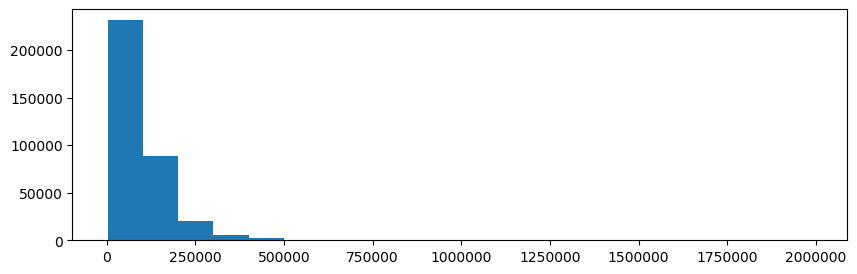

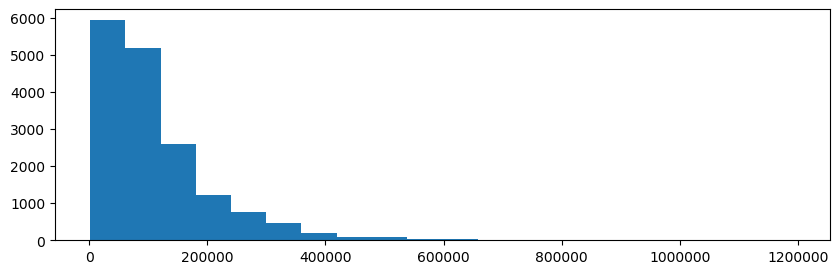

In [22]:
## order 기준으로 다시그리기
## 구매 된 제품 가격대(order price)
plt.figure(figsize=(10,3))
plt.hist(order['PROD_PRC'], bins = 20)
plt.show()

## 구매 된 제품 가격대(order price)
plt.figure(figsize=(10,3))
plt.hist(item['MALL_SALE_PRC'], bins = 20)
plt.show()

In [322]:
# item[item['PROD_CD'].isin(order[order['PROD_PRC'] >= 1000000]['PROD_CD'].unique())]
# print(item[item['MALL_SALE_PRC'] >= 1000000])

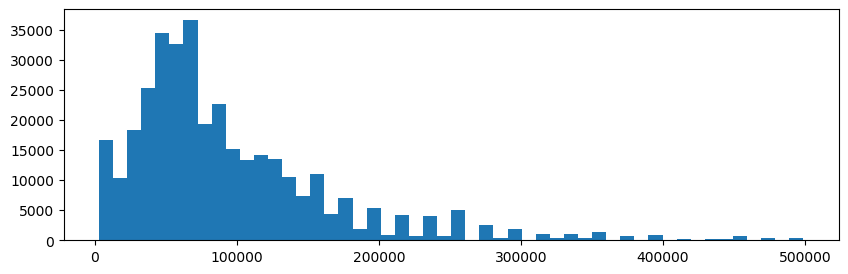

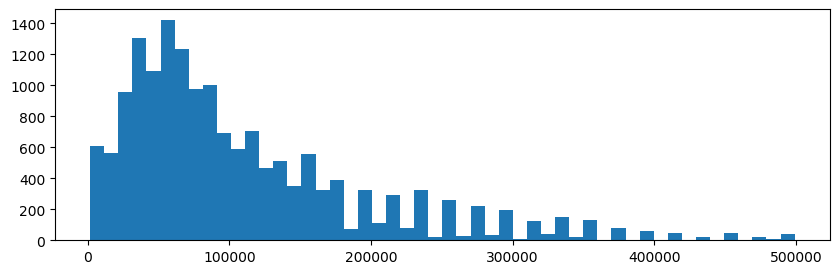

In [23]:
## 100만원 이상 제품 제외

## 구매 된 제품 가격대(order price)
plt.figure(figsize=(10,3))
plt.hist(order[order['PROD_PRC'] <500000]['PROD_PRC'], bins = 50)
plt.show()

## 구매 된 제품 가격대(order price)
plt.figure(figsize=(10,3))
plt.hist(item[item['MALL_SALE_PRC'] <500000]['MALL_SALE_PRC'], bins = 50)
plt.show()

In [324]:
## 가격대가 낮은 제품 파악 -- 양말 등의 기본 용품
# item[item['PROD_CD'].isin(order[order['PROD_PRC'] <= 10000]['PROD_CD'].unique())]['PROD_NM'].unique()
# item[item['MALL_SALE_PRC'] <= 10000]['CATEGORY_S'].unique()

### - Order data format change

In [24]:
order['TIMESTAMP'] = [datetime.datetime.timestamp(i) for i in order['REG_DT']]
order['TIMESTAMP'] = order['TIMESTAMP'].astype('long')
order['USER_ID'] = order['USR_ID'].astype('str')
order['ITEM_ID'] = order['PROD_CD'].astype('str')
order['EVENT_TYPE'] = 'Purchase'

In [25]:
temp_order = order[['USER_ID','ITEM_ID','TIMESTAMP','EVENT_TYPE']].copy()

## User Data

In [26]:
## 2021년 5월 3일 ~ 2022년 10월 31일 (1년 반 데이터)
users['REG_DT'] = pd.to_datetime(users['REG_DT'])
print(f'{users["REG_DT"].min()} ~ {users["REG_DT"].max()}')

2021-05-03 00:00:00 ~ 2022-11-01 00:00:00


In [27]:
users.isna().sum()

USR_ID       0
GENDER       0
AGE          0
DST_GRADE    0
LCS_GRADE    0
UMB_GRADE    0
DSG_GRADE    0
LCG_GRADE    0
MSW_GRADE    0
REG_DT       0
dtype: int64

In [28]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124623 entries, 0 to 124622
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   USR_ID     124623 non-null  object        
 1   GENDER     124623 non-null  object        
 2   AGE        124623 non-null  int64         
 3   DST_GRADE  124623 non-null  object        
 4   LCS_GRADE  124623 non-null  object        
 5   UMB_GRADE  124623 non-null  object        
 6   DSG_GRADE  124623 non-null  object        
 7   LCG_GRADE  124623 non-null  object        
 8   MSW_GRADE  124623 non-null  object        
 9   REG_DT     124623 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(8)
memory usage: 10.5+ MB


In [79]:
brand_list = ["DST_GRADE"
              ,"LCS_GRADE","UMB_GRADE","DSG_GRADE","LCG_GRADE","MSW_GRADE"
             ]
grade_list = ['bronze', 'silver', 'gold', 'vip']
temp_count = []
temp_price = []
temp_grade = []
temp_brand = []

for brand in brand_list:    
    
    for grade in grade_list:
        # print("")
        temp_count.append(order[order["USR_ID"].isin(users[users[brand] == grade].USR_ID.unique())].shape[0])
        temp_price.append(order[order["USR_ID"].isin(users[users[brand] == grade].USR_ID.unique())]["PROD_PRC"].sum())
        temp_grade.append(grade)
        temp_brand.append(brand)
        # print(f'{brand} 브랜드 {grade} 고객 구매 횟수 : {order[order["USR_ID"].isin(users[users[brand] == grade].USR_ID.unique())].shape[0]}')
        # print(f'{brand} 브랜드 {grade} 고객 구매 가격 평균 : {order[order["USR_ID"].isin(users[users[brand] == grade].USR_ID.unique())]["PROD_PRC"].mean()}')
        
temp_df = pd.DataFrame()
temp_df['count'] = temp_count
temp_df['price'] = temp_price
temp_df['grade'] = temp_grade
temp_df['brand'] = temp_brand

temp_df.dropna(inplace = True)

In [80]:
temp_df.to_csv('user_price_count_ver_2_sum.csv')

DST_GRADE


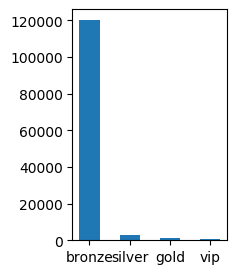

LCS_GRADE


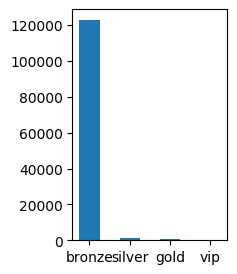

UMB_GRADE


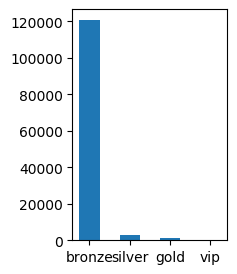

DSG_GRADE


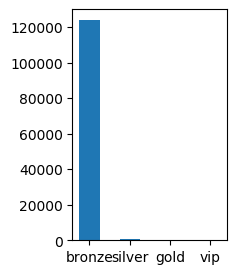

LCG_GRADE


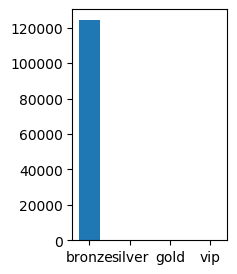

MSW_GRADE


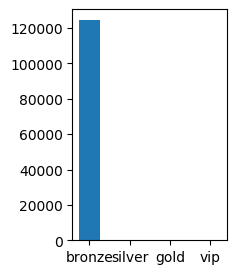

In [37]:
for i in ["DST_GRADE","LCS_GRADE","UMB_GRADE","DSG_GRADE","LCG_GRADE","MSW_GRADE"]:
    print(i)
    plt.figure(figsize =(2,3))
    plt.bar(users[i].value_counts().index, users[i].value_counts(),  width = 0.5)
    # plt.ylim(0,5000)
    plt.show()
    input()

In [38]:
order['BRAND_CD'].value_counts()

U    131607
S    101791
Q     66633
D     26100
G     14761
M      8875
Name: BRAND_CD, dtype: int64

In [51]:
temp.sort_values('REG_DT', ascending = False).head(10)

,index,REG_DT
182,2021-11-02,460
181,2021-11-01,380
393,2022-06-01,363
413,2022-06-21,322
183,2021-11-03,322
407,2022-06-15,305
362,2022-05-01,304
364,2022-05-03,300
408,2022-06-16,298
187,2021-11-07,297


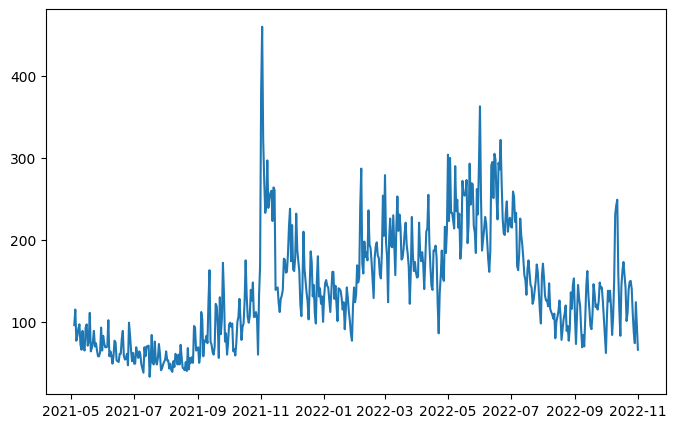

In [47]:
## 일자별 유저 가입자 수 추이
temp = pd.DataFrame(users[users['REG_DT'] != '2021-05-03 00:00:00']['REG_DT'].value_counts().sort_index())
temp.reset_index(drop = False, inplace = True)

plt.figure(figsize =(8,5))
plt.plot(temp['index'], temp['REG_DT'])
plt.show()

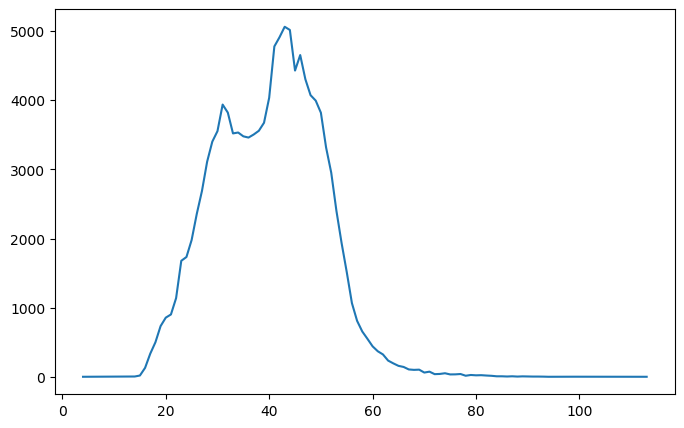

In [82]:
## 나이별 유저 가입자 수 추이
temp = pd.DataFrame(users['AGE'].value_counts().sort_index())
temp.reset_index(drop = False, inplace = True)

plt.figure(figsize =(8,5))
plt.plot(temp['index'], temp['AGE'])
plt.show()

In [85]:
users['AGE'].max()

113

In [83]:
users[users['AGE'] >= 60]

,USR_ID,GENDER,AGE,DST_GRADE,LCS_GRADE,UMB_GRADE,DSG_GRADE,LCG_GRADE,MSW_GRADE,REG_DT
36,+eQ7ptvJvbNGYjzeYZKACw==,M,60,bronze,bronze,bronze,bronze,bronze,bronze,2021-05-04
62,+E2NaiuDrMG65pSYGXfUBw==,W,73,bronze,bronze,bronze,bronze,bronze,bronze,2021-05-04
105,XdUdSzt+T2a/s5Si6reSLQ==,W,69,bronze,bronze,bronze,bronze,bronze,bronze,2021-05-03
182,Nex9UK+SWofqWewYHC1frQ==,M,66,bronze,bronze,bronze,bronze,bronze,silver,2021-05-05
251,m0G2U3+k1ZusxGcxlVlgfQ==,W,67,bronze,bronze,bronze,bronze,bronze,bronze,2021-05-03
...,...,...,...,...,...,...,...,...,...,...
124455,SoUXtRuvAR/1gOQM8PE1Rg==,W,60,bronze,bronze,bronze,bronze,bronze,bronze,2022-10-30
124456,xZUmHoU+ftjLjnbuM9Wisw==,W,66,bronze,bronze,bronze,bronze,bronze,bronze,2022-10-30
124466,oTczUR2icwLtFIALrdLKBg==,M,62,bronze,bronze,bronze,bronze,bronze,bronze,2022-10-30
124477,Gd1BWMLqJffWCK4efpA11Q==,M,66,bronze,bronze,bronze,bronze,bronze,bronze,2022-10-30


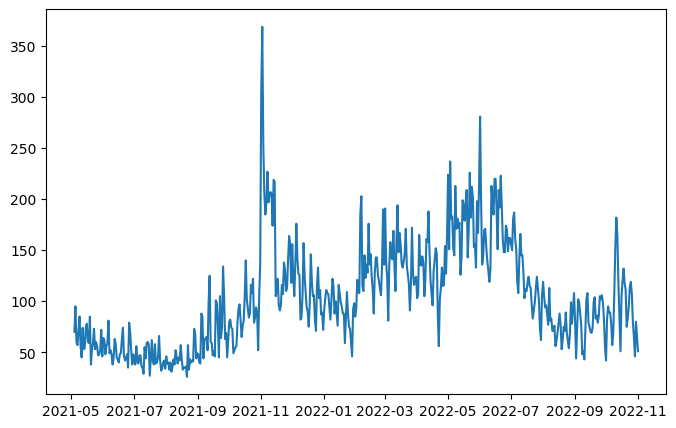

In [54]:
temp = pd.DataFrame(users[(users['AGE'].isin([i for i in range(30,55)])) & (users['REG_DT'] != '2021-05-03 00:00:00')]['REG_DT'].value_counts().sort_index())
temp.reset_index(drop = False, inplace = True)

plt.figure(figsize =(8,5))
plt.plot(temp['index'], temp['REG_DT'])
plt.show()

In [55]:
users[users['AGE']>=60].shape

(2739, 10)

In [56]:
users['AGE'].max()

113

In [57]:
users['GENDER'].value_counts()

W    66545
M    58078
Name: GENDER, dtype: int64

In [58]:
for i in list(users):
    print(f'"{i}" column has {users[i].nunique()} unique values')

"USR_ID" column has 124623 unique values
"GENDER" column has 2 unique values
"AGE" column has 83 unique values
"DST_GRADE" column has 4 unique values
"LCS_GRADE" column has 4 unique values
"UMB_GRADE" column has 4 unique values
"DSG_GRADE" column has 4 unique values
"LCG_GRADE" column has 4 unique values
"MSW_GRADE" column has 4 unique values
"REG_DT" column has 548 unique values


In [59]:
for i in ["DST_GRADE","LCS_GRADE","UMB_GRADE","DSG_GRADE","LCG_GRADE","MSW_GRADE"]:
    print(f"{i} unique : {users[i].unique()}")

DST_GRADE unique : ['bronze' 'silver' 'vip' 'gold']
LCS_GRADE unique : ['bronze' 'gold' 'vip' 'silver']
UMB_GRADE unique : ['bronze' 'vip' 'gold' 'silver']
DSG_GRADE unique : ['bronze' 'vip' 'gold' 'silver']
LCG_GRADE unique : ['bronze' 'silver' 'gold' 'vip']
MSW_GRADE unique : ['bronze' 'gold' 'silver' 'vip']


## Item Data

In [60]:
## 2021년 5월 3일 ~ 2022년 10월 31일 (1년 반 데이터)
item['REG_DT'] = pd.to_datetime(item['REG_DT'])
print(f'{item["REG_DT"].min()} ~ {item["REG_DT"].max()}')

2019-11-11 00:00:00 ~ 2022-10-28 00:00:00


In [61]:
item.isna().sum()

PROD_CD              0
COLOR_CD             0
PROD_NM              0
COLOR_NM             0
ITEM_NM              0
GENDER               0
BRND_NM              0
MALL_SALE_PRC        0
REG_DT               0
CATEGORY_S         109
TECH_NM_LIST     16025
FIT_NM_LIST      15331
IMG_URL              0
dtype: int64

In [62]:
item[item['CATEGORY_S'].isna()].to_csv('category_na.csv')

In [63]:
item.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16641 entries, 0 to 16640
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   PROD_CD        16641 non-null  object        
 1   COLOR_CD       16641 non-null  object        
 2   PROD_NM        16641 non-null  object        
 3   COLOR_NM       16641 non-null  object        
 4   ITEM_NM        16641 non-null  object        
 5   GENDER         16641 non-null  object        
 6   BRND_NM        16641 non-null  object        
 7   MALL_SALE_PRC  16641 non-null  int64         
 8   REG_DT         16641 non-null  datetime64[ns]
 9   CATEGORY_S     16532 non-null  object        
 10  TECH_NM_LIST   616 non-null    object        
 11  FIT_NM_LIST    1310 non-null   object        
 12  IMG_URL        16641 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(11)
memory usage: 1.8+ MB


In [64]:
## 동일 상품코드임에도 여러개의 아이템 존재 (색상만 다름)
item['PROD_CD'].value_counts()
item[item['PROD_CD'] == 'GM121MTS31']

,PROD_CD,COLOR_CD,PROD_NM,COLOR_NM,ITEM_NM,GENDER,BRND_NM,MALL_SALE_PRC,REG_DT,CATEGORY_S,TECH_NM_LIST,FIT_NM_LIST,IMG_URL
7455,GM121MTS31,LVND,남성 듀얼 플렉스(DUAL FLEX) 반팔 티셔츠,Lavender,SHORTS SLEEVE T-SHIRTS,MAN,르꼬끄골프,47200,2021-01-28,"긴팔/반팔티셔츠,반팔티셔츠",NaN,NaN,//images.descentekorea.co.kr/product/G/M1/GM12...
7456,GM121MTS31,CORA,남성 듀얼 플렉스(DUAL FLEX) 반팔 티셔츠,Coral,SHORTS SLEEVE T-SHIRTS,MAN,르꼬끄골프,47200,2021-01-28,"긴팔/반팔티셔츠,반팔티셔츠",NaN,NaN,//images.descentekorea.co.kr/product/G/M1/GM12...
7457,GM121MTS31,WHTE,남성 듀얼 플렉스(DUAL FLEX) 반팔 티셔츠,white,SHORTS SLEEVE T-SHIRTS,MAN,르꼬끄골프,47200,2021-01-28,"긴팔/반팔티셔츠,반팔티셔츠",NaN,NaN,//images.descentekorea.co.kr/product/G/M1/GM12...
7458,GM121MTS31,SPNK,남성 듀얼 플렉스(DUAL FLEX) 반팔 티셔츠,SPNK(PINK),SHORTS SLEEVE T-SHIRTS,MAN,르꼬끄골프,47200,2021-01-28,"긴팔/반팔티셔츠,반팔티셔츠",NaN,NaN,//images.descentekorea.co.kr/product/G/M1/GM12...
7459,GM121MTS31,MOSS,남성 듀얼 플렉스(DUAL FLEX) 반팔 티셔츠,MOSS,SHORTS SLEEVE T-SHIRTS,MAN,르꼬끄골프,47200,2021-01-28,"긴팔/반팔티셔츠,반팔티셔츠",NaN,NaN,//images.descentekorea.co.kr/product/G/M1/GM12...
7460,GM121MTS31,DGRN,남성 듀얼 플렉스(DUAL FLEX) 반팔 티셔츠,D/GREEN,SHORTS SLEEVE T-SHIRTS,MAN,르꼬끄골프,47200,2021-01-28,"긴팔/반팔티셔츠,반팔티셔츠",NaN,NaN,//images.descentekorea.co.kr/product/G/M1/GM12...
7461,GM121MTS31,BLCK,남성 듀얼 플렉스(DUAL FLEX) 반팔 티셔츠,BLCK,SHORTS SLEEVE T-SHIRTS,MAN,르꼬끄골프,47200,2021-01-28,"긴팔/반팔티셔츠,반팔티셔츠",NaN,NaN,//images.descentekorea.co.kr/product/G/M1/GM12...


In [351]:
## 동일 제품명이지만, 카테고리, 시즌 등이 다름
item[item['PROD_NM'] == 'SNUG (스너그)'][['PROD_CD','PROD_NM']].drop_duplicates()

,PROD_CD,PROD_NM
2109,UM323EMU90,SNUG (스너그)
8648,UN323CMU90,SNUG (스너그)
9313,UN223EMU40,SNUG (스너그)
11027,UN423CMUO2,SNUG (스너그)
11029,UN423CMUO1,SNUG (스너그)


In [352]:
## 동일 제품명이지만, 시즌정보, 성별정보, 아이템 코드에 따라 다양한 제품으로 분류됨 (추후 같은 제품으로 인지하고 진행해야 할 지?)
item[item['PROD_NM'] == '에너자이트 제트 플러스']

,PROD_CD,COLOR_CD,PROD_NM,COLOR_NM,ITEM_NM,GENDER,BRND_NM,MALL_SALE_PRC,REG_DT,CATEGORY_S,TECH_NM_LIST,FIT_NM_LIST,IMG_URL
1643,SM313RRN71,YLWH,에너자이트 제트 플러스,YELLOW/WHITE,RUNNING,UNISEX,데상트,101400,2021-06-10,"러닝,런닝화",NaN,NaN,//images.descentekorea.co.kr/product/S/M3/SM31...
1644,SM313RRN71,WHT0,에너자이트 제트 플러스,WHT,RUNNING,UNISEX,데상트,101400,2021-06-10,"러닝,런닝화",NaN,NaN,//images.descentekorea.co.kr/product/S/M3/SM31...
1645,SM313RRN71,SLBK,에너자이트 제트 플러스,SILVER / BLACK,RUNNING,UNISEX,데상트,101400,2021-06-10,"러닝,런닝화",NaN,NaN,//images.descentekorea.co.kr/product/S/M3/SM31...
1646,SM313RRN71,RED0,에너자이트 제트 플러스,RED,RUNNING,UNISEX,데상트,101400,2021-06-10,"러닝,런닝화",NaN,NaN,//images.descentekorea.co.kr/product/S/M3/SM31...
1647,SM313RRN71,GRY0,에너자이트 제트 플러스,Grey,RUNNING,UNISEX,데상트,101400,2021-06-10,"러닝,런닝화",NaN,NaN,//images.descentekorea.co.kr/product/S/M3/SM31...
1648,SM313RRN71,BLK0,에너자이트 제트 플러스,BLK,RUNNING,UNISEX,데상트,101400,2021-06-10,"러닝,런닝화",NaN,NaN,//images.descentekorea.co.kr/product/S/M3/SM31...
1649,SM313RRN71,BLE0,에너자이트 제트 플러스,BLUE,RUNNING,UNISEX,데상트,101400,2021-06-10,"러닝,런닝화",NaN,NaN,//images.descentekorea.co.kr/product/S/M3/SM31...
2717,SM113RRN11,WHT0,에너자이트 제트 플러스,WHT,RUNNING,UNISEX,데상트,118300,2021-01-18,"러닝,런닝화",NaN,NaN,//images.descentekorea.co.kr/product/S/M1/SM11...
2718,SM113RRN11,WHBK,에너자이트 제트 플러스,WHITE / BLACK,RUNNING,UNISEX,데상트,118300,2021-01-18,"러닝,런닝화",NaN,NaN,//images.descentekorea.co.kr/product/S/M1/SM11...
2719,SM113RRN11,SVWH,에너자이트 제트 플러스,SILVER WHITE,RUNNING,UNISEX,데상트,118300,2021-01-18,"러닝,런닝화",NaN,NaN,//images.descentekorea.co.kr/product/S/M1/SM11...


In [353]:
모든 브랜드를 통합하여 Personalize를 진행할 것인지, 별도로 진행할 것인지 확인 필요

SyntaxError: invalid syntax (<ipython-input-353-c2f17d108335>, line 1)

In [354]:
print(item['MALL_SALE_PRC'].min(), item['MALL_SALE_PRC'].max())
print(order['PROD_PRC'].min(), order['PROD_PRC'].max())

1740 1194000
2800 1990000


In [365]:
item[item['MALL_SALE_PRC'] == item['MALL_SALE_PRC'].min()]

,PROD_CD,COLOR_CD,PROD_NM,COLOR_NM,ITEM_NM,GENDER,BRND_NM,MALL_SALE_PRC,REG_DT,CATEGORY_S,TECH_NM_LIST,FIT_NM_LIST,IMG_URL
4601,SM123ASA22,WHT0,다이컷 인솔,WHT,SHOES ACC,UNISEX,데상트,1740,2021-02-19,"기타,양말",NaN,NaN,//images.descentekorea.co.kr/product/S/M1/SM12...


In [366]:
item[item['PROD_CD'].isin(order[order['PROD_PRC'] == order['PROD_PRC'].min()]['PROD_CD'].values)]

,PROD_CD,COLOR_CD,PROD_NM,COLOR_NM,ITEM_NM,GENDER,BRND_NM,MALL_SALE_PRC,REG_DT,CATEGORY_S,TECH_NM_LIST,FIT_NM_LIST,IMG_URL
3089,QM123ASC11,WHT0,베이직 페이크삭스,WHT,SOCKS,UNISEX,르꼬끄,2800,2020-12-24,양말,NaN,NaN,//images.descentekorea.co.kr/product/Q/M1/QM12...
3090,QM123ASC11,DMR0,베이직 페이크삭스,DMR,SOCKS,UNISEX,르꼬끄,2800,2020-12-24,양말,NaN,NaN,//images.descentekorea.co.kr/product/Q/M1/QM12...
3091,QM123ASC11,BLK0,베이직 페이크삭스,BLK,SOCKS,UNISEX,르꼬끄,2800,2020-12-24,양말,NaN,NaN,//images.descentekorea.co.kr/product/Q/M1/QM12...


In [129]:
item['GENDER'].unique()

array(['WOMAN', 'MAN', 'UNISEX'], dtype=object)

In [133]:
item['ITEM_NM'].unique()

array(['SW', 'CUT&SAW', 'SHORT SLEEVE T-SHIRTS', 'WOVEN TOP', 'CAP',
       'FLEECE PANTS', 'KNIT 단품 FLEECE JACKET', 'LONG SLEEVE T-SHIRTS',
       'SHORTS SLEEVE T-SHIRTS', 'TS', 'ESSENTIAL 퍼포먼스 SHOES', 'SNEAKERS',
       'RUNNING', 'JACKET', 'TL', 'PANTS', 'FLEECE T', 'TRAINING',
       'CLASSIC RUNNING', 'KNIT LEGGINGS', 'HEAVY T/SHIRTS (TERRY)',
       'BACK PACK', 'HALF PANTS', 'LONG SLEEVE T- SHIRTS ', 'FLEECE TOP',
       'SLIDE', 'PANTS FOR FITNESS', 'SOCKS', 'WARMER', 'WOVEN VEST',
       'KNIT CAP', 'ETC', 'BAG', 'WIND BREAK', 'KNIT OUTER', 'CUPSOLE',
       'BRA-TOP', 'FLEECE JACKET', 'BACKPACK', 'ONEPIECE',
       'FLEECE ZIP-UP', 'KIDS', 'SKIRT', 'DOWN JACKET', 'WARM UP PANTS',
       'ACCESSORY OTHERS', 'LONG PANTS', 'BOOTS', 'SKI PANTS',
       'SKI JACKET', 'KNIT PULLOVER', 'PADDING JACKET', 'WOVEN PANTS',
       'VULCANIZING', 'WARM UP JACKET', 'JP', 'GLOVE', 'IN',
       'KNIT 단품 FLEECE PANTS', 'SHOES', 'DOWN VEST', 'HOODED SWEAT', 'SK',
       'PT', 'DOWN JUMPER', 'S

In [160]:
item['COLOR_NM'].unique()

array(['NAVY', 'Bright White', 'BLACK', 'Bleached Aqua', 'WHT', 'ORANGE',
       'BLK', 'RED', 'BLCK', 'ROYAL BLUE', '(MGR0)H. GREY', 'CORAL',
       'white', 'NeonPink', 'PINK', '(OWHT)O.White', 'KHAKI', 'BEIGE',
       'PINK / WHITE', 'Melange Charcaol', 'Birch', 'GREY ORANGE',
       'PATTERN', 'LIME', 'T.BLUE', 'CHARCOAL GREY', 'Mustard',
       'DIET ORANGE', 'CBG0', 'CML', 'DARK OLIVE', 'CREAM', 'BURGUNDY',
       'FOD0', 'YELLOW', 'MUS0', 'D NAVY', 'BIG', 'GREEN / WHITE', 'Grey',
       'BLUE', 'OFF-WHITE', 'LILAC', 'SILVER', 'BLACK / WHITE', 'IVORY',
       'PBD0', 'DTG0', 'ABSOLUTE BLUE', 'Black Pattern', 'CTL0',
       'SURF BLUE', 'PGR0', 'NYL', 'OLIVE', 'WHITE/BLUE/RED',
       'Physical NEON CORAL', 'Physical D.GREEN', 'LOTUS PINK', 'DMR',
       'LIGHT MINT', 'ASH KHAKI', 'TRED', 'WHITE / BLACK', 'P BLUE',
       'PORG', 'WHITE X BLACK', 'MOV0', 'IPK0', 'DENIM', 'CRIMSON',
       'GREY', 'TRICOLOR', 'PEACH PINK', 'GSN0', 'WONDERLAND PINK',
       'khaki grey', 'IPP', '(MG

In [136]:
item['COLOR_NM'].nunique()

632

In [135]:
item['COLOR_NM'].str.upper().nunique()

582

In [52]:
## 아이템 명이 같지만 상품코드가 다름 (세부 내용으로 구분)
for i in list(item):
    print(f'"{i}" column has {item[i].nunique()} unique values')

"PROD_CD" column has 4970 unique values
"COLOR_CD" column has 696 unique values
"PROD_NM" column has 4735 unique values
"COLOR_NM" column has 632 unique values
"ITEM_NM" column has 142 unique values
"GENDER" column has 3 unique values
"BRND_NM" column has 6 unique values
"MALL_SALE_PRC" column has 448 unique values
"REG_DT" column has 588 unique values
"CATEGORY_S" column has 562 unique values
"TECH_NM_LIST" column has 50 unique values
"FIT_NM_LIST" column has 53 unique values
"IMG_URL" column has 11405 unique values


In [138]:
item['GENDER'].value_counts()

UNISEX    4755
MAN       3410
WOMAN     3240
Name: GENDER, dtype: int64

In [53]:
## 브랜드 개수 6개
print(f'Brand Name Num : {item["BRND_NM"].nunique()}')
item['BRND_NM'].value_counts()

Brand Name Num : 6


데상트      3770
르꼬끄      2641
엄브로      2124
데상트골프    1170
르꼬끄골프     910
먼싱웨어      790
Name: BRND_NM, dtype: int64

## Data Join

In [65]:
total_df = order.merge(item, on = ['COLOR_CD', 'PROD_CD'])
total_df.rename({'GENDER' : 'BUY_GENDER'}, axis = 1, inplace = True)
total_df = total_df.merge(users, on =['USR_ID'])
total_df.drop(['REG_DT_x', 'REG_DT_y', 'REG_DT'], axis = 1, inplace = True)

In [72]:
temp_df = total_df[['PROD_QTY', 'PROD_PRC', 'ORD_CHANNEL', 'BUY_GENDER', 'BRND_NM', 'GENDER', 
                    'AGE', 'DST_GRADE', 'LCS_GRADE', 'UMB_GRADE', 'DSG_GRADE', 'LCG_GRADE', 'MSW_GRADE']].select_dtypes('int')
total_df['BRND_NM'] = np.where(total_df['BRND_NM'] =='데상트', 'dsc', 
                               np.where(total_df['BRND_NM'] =='르꼬끄', 'lcs',
                                        np.where(total_df['BRND_NM'] =='엄브로', 'umb',
                                                np.where(total_df['BRND_NM'] =='데상트골프', 'dsc',
                                                        np.where(total_df['BRND_NM'] =='르꼬끄골프', 'lcg',
                                                                 np.where(total_df['BRND_NM'] =='먼싱웨어', 'msw', total_df['BRND_NM']))))))

for i in total_df[['PROD_QTY', 'PROD_PRC', 'ORD_CHANNEL', 'BUY_GENDER', 'BRND_NM', 'GENDER', 'AGE', 
                   # 'DST_GRADE', 'LCS_GRADE', 'UMB_GRADE', 'DSG_GRADE', 'LCG_GRADE', 'MSW_GRADE'
                  ]].select_dtypes('object').columns:
    temp_df = temp_df.merge(pd.get_dummies(total_df[[i]], prefix=[i]), right_index = True, left_index = True)
    
cor_matrix = temp_df.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
high_score_set = set()

for key, row in upper_tri.iterrows():
    for col in upper_tri.columns:
        if row[col] > 0.5:
            high_score_set.add(key)
            high_score_set.add(col)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


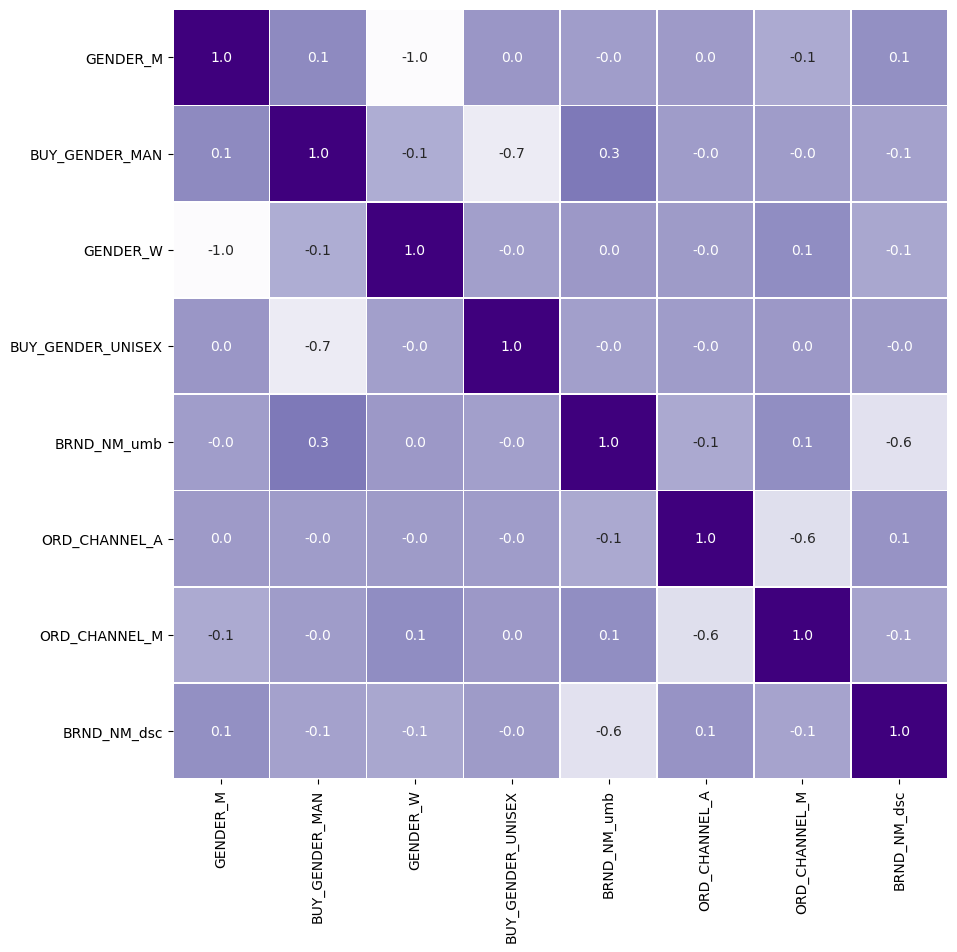

In [73]:
## 르꼬끄 구매와 데상트 구매가 대비됨
## 엄브로 구매와 데상트 구매가 대비됨

plt.figure(figsize=(10,10))
sns.heatmap(data = temp_df[high_score_set].corr(), annot=True, fmt = '.1f', cmap='Purples', linewidths=.5, cbar = False)
plt.show()